# Use PyMC3 as a baseline to test other techniques
https://docs.pymc.io/notebooks/GP-Marginal.html

In [2]:
import pymc3 as pm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy import signal
from scipy.sparse import linalg as sla
from scipy import linalg as la
from tqdm import tqdm
from scipy.optimize import minimize

from oceanoi import cov, oi, variogram

1.0

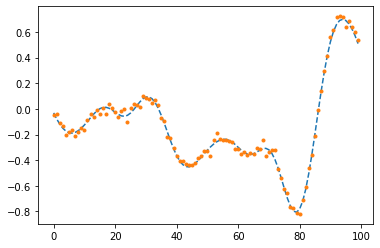

In [3]:
np.random.seed(1) # this generates the same output every time
# Generate some training data

covfunc = cov.expquad_1d
noise = 0.03
η_true = 0.3
ℓ_true = 7.
dx = 1.

N = 100
xd = np.arange(0,dx*N,dx)
xo = np.linspace(-10*dx,dx*N+dx*10,N*10)

covparams = (η_true, ℓ_true)
K = covfunc(xd[:,None], xd[:,None].T, covparams)

# L = la.cholesky(K+1e-7*np.eye(N))
# yd = L.dot(noise*np.random.normal(size=(N,)))

mu = np.zeros_like(xd)
yd = np.random.multivariate_normal(mu.ravel(), K+1e-8*np.eye(N), 1).ravel()
y = yd+noise*np.random.normal(size=(N,))

X = xd[:,None]

plt.figure()
plt.plot(X, yd,'--')
plt.plot(X, y,'.')
dx

In [4]:
with pm.Model() as marginal_gp_model:
    # Priors
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=1)
    σ = pm.HalfCauchy("σ", beta=1)
    
    bigno = 10
    #ℓ = pm.Uniform('ℓ', lower=0, upper=bigno)
    #η = pm.Uniform('η', lower=0, upper=bigno)
    #σ = pm.Uniform('σ', lower=0, upper=bigno)

    # Specify the covariance function.
    K = η ** 2 * pm.gp.cov.ExpQuad(1, ℓ)
    gp = pm.gp.Marginal(cov_func=K)

    y_ = gp.marginal_likelihood("y", X=X, y=y, noise=σ)
    
    # Compute the marginal posterior
    mp = pm.find_MAP()
    
    #trace = pm.sample()

In [5]:
mp, ℓ_true, η_true, noise 

({'ℓ_log__': array(2.00374141),
  'η_log__': array(-1.0154081),
  'σ_log__': array(-3.54843843),
  'ℓ': array(7.41675333),
  'η': array(0.36225456),
  'σ': array(0.02876953)},
 7.0,
 0.3,
 0.03)

https://github.com/pymc-devs/pymc3/blob/master/pymc3/distributions/multivariate.py

In [6]:
def log_marginal_likelihood(K, zd):
    
    N = zd.shape[0]

    #W = la.solve(Kdd, yd)
    # Cholesky needs some noise...
    try:
        L = la.cholesky(K+1e-8*np.eye(N))
    except:
        return -np.inf

    S1 = la.solve_triangular(L, zd, lower=True)
    S2 = la.solve_triangular(L.T, S1, lower=False)

    return -np.sum(np.log(np.diagonal(L))) - \
                0.5 * zd.dot(S2) - \
                0.5 * N * np.log(2*np.pi)

def log_marginal_likelihood_1d(xd, zd, sd, cov_func, cov_params):
    
    N = xd.shape[0]
    I = np.diag(np.ones((N)))
    K = cov_func(xd[:,None], xd[:,None].T, cov_params) + sd**2*I
    
    return log_marginal_likelihood(K, zd)

def log_marginal_likelihood_3d(xd, yd, td, zd, sd, cov_func, cov_params):
    
    N = xd.shape[0]
    I = np.diag(np.ones((N)))
    
    K = cov_func(xd[:,None], yd[:,None], td[:,None], xd[:,None].T, yd[:,None].T, td[:,None].T, cov_params) + sd**2*I
    
    return log_marginal_likelihood(K, zd)


###
# OI classes
class OptimalInterp1D_v2(object):
    """
    Optimal interpolation in one dimension (usually time)
    
    """
    
    def __init__(self, xd, xm, sd, cov_func, cov_params):
        
        self.N = xd.shape[0]
        self.M = xm.shape[0]    
        self.xd = xd
        self.xm = xm
        
        self.cov_params = cov_params
        self.cov_func = cov_func

        # Compute the covariance functions
        self.Kmd = cov_func(xm[:,None], xd[:,None].T, cov_params)
        #self.Kmd = cov_func(xm[:,None], xd[:,None].T, cov_params)
        #self.Kmd = cov_func(xm[None,:], xd[:,None], cov_params)

        #rint(self.Kmd.shape, self.M, self.N)
        self.Kdd = cov_func(xd[:,None], xd[:,None].T, cov_params) 
        noise = sd**2*np.eye(self.N)
        
        # Calculate the choelsky factorization
        #self.L = la.cholesky(self.Kdd+noise+1e-7*np.eye(self.N), lower=True)
        #self.L, self.lower = la.cho_factor(self.Kdd+noise+1e-8*np.eye(self.N))
        # Calculate the weights
        #self.w_md = la.solve_triangular(self.L,  self.Kmd, lower=True)
        
        # This way works
        #self.w_md = self._calc_weights(self.Kdd, sd, self.Kmd.T)
        
        
        # This way also works...
        self.L = la.cholesky(self.Kdd+noise+1e-7*np.eye(self.N), lower=True)
        self.w_md = la.cho_solve((self.L, True),  self.Kmd.T)

        #self.w_md = la.solve_triangular(self.L,  self.Kmd.T, lower=False)
        #self.L = la.cholesky(Kdd+noise)
        #self.Kmd = Kmd
        
    def __call__(self, yd):
        
        assert yd.shape[0] == self.N, ' first dimension in input data must equal '
        
        #a1 = la.solve_triangular(self.L, yd, )
        #alpha = la.solve_triangular(self.L.T, a1,)
        #print(alpha.shape, self.Kmd.T.shape)
        #return np.dot(self.Kmd, alpha)
        
        #v = la.solve_triangular(self.L, yd)
        #return np.dot(self.w_md.T, v)
        #return np.dot(self.w_md, yd[:,:])
        
        #v = la.cho_solve((self.L, self.lower), yd, )
        #A = la.cho_solve((self.L.T, self.lower), v,)
        #return np.dot(self.Kmd, A)
        
        return np.dot(self.w_md.T, yd[:,:])
    
    def calc_err(self):
        Kmm = self.cov_func(self.xm[:,None], self.xm[:,None].T, self.cov_params)
        Kdm = self.cov_func(self.xd[:,None], self.xm[:,None].T, self.cov_params)
        V = Kmm - self.w_md.T.dot(Kdm)

        return np.diagonal(V)
    
    def log_marg_likelihood(self, yd):
        
        logdet = 2*np.sum(np.log(np.diagonal(self.L)))
        
        v = la.cho_solve((self.L, True), yd )
        
        qdist = np.dot(yd.T, v)[0,0]
        
        fac = self.N * np.log(2*np.pi)
        
        #rint(logdet, qdist, fac)
        
        return -0.5*(logdet + qdist + fac)
        
            
         #return -np.sum(np.log(np.diagonal(L))) - \
         #       0.5 * zd.dot(S2) - \
         #       0.5 * N * np.log(2*np.pi)
    
    def neg_log_marginal_likelihood(self, xd, yd, sd, cov_func, cov_params):
        
        #mu = self.__call__(yd)
        mu = 0
        zd = yd - mu
        
        return -log_marginal_likelihood_1d(xd, zd.ravel(), sd, cov_func, cov_params)
    
    def _calc_weights(self, K, sd, Ks):
        # noise term 
        #I = np.diag(np.ones((self.n,)))
        I = np.eye(self.N)
        noise = sd**2*I
        
        return la.solve(K+noise, Ks)
    

CPU times: user 72.8 ms, sys: 119 ms, total: 192 ms
Wall time: 73.6 ms


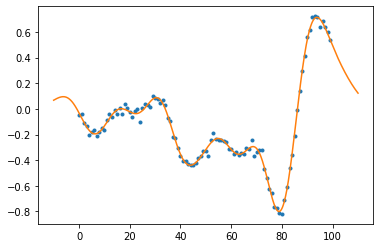

In [7]:
%%time
# Create a 3D OI object

scale = 1

OI = OptimalInterp1D_v2(X.ravel()*scale,  \
                            xo*scale,\
                            noise, covfunc, covparams)

yoi = OI(y[:,None])

plt.figure()
plt.plot(X, y,'.')
plt.plot(xo, yoi,'')

In [8]:
OI.log_marg_likelihood(y[:,None])

162.19749463446493

In [10]:
# Minimize the log marginal likelihood
def minfunc( params, x, Z, covfunc):
    #print(params)
    noise = params[0]
    covparams = params[1:]
    
    myOI = OptimalInterp1D_v2(x, x, noise, covfunc, covparams)
    #nll = myOI.neg_log_marginal_likelihood(x, Z, noise, covfunc, covparams)
    nll = -myOI.log_marg_likelihood(Z)

    #     print(nll)
    return nll

method = 'L-BFGS-B'
bounds =( (0.01,1), (0.05,2*dx), (0.2, 20.)) 
#bounds = None
covparams_ic = (0.5, 0.5, 12)
options = None #{'eps':1e-6}

# def optlog(x):
#     print(x)

soln = minimize(minfunc, covparams_ic,
         args=(xd*scale,  yd[:,None],  covfunc),
            method=method,
            bounds=bounds,
            options=options,
         ) 
soln['x'],  noise,  η_true, ℓ_true,

(array([0.01      , 0.39246629, 7.66485526]), 0.03, 0.3, 7.0)

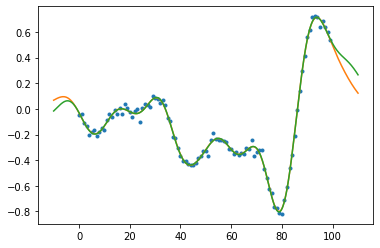

In [11]:

OI1 = OptimalInterp1D_v2(X.ravel()*scale,  \
                            xo*scale,\
                            noise, covfunc, covparams)

yoi1 = OI1(y[:,None])

OI2 = OptimalInterp1D_v2(X.ravel()*scale,  \
                            xo*scale,\
                            soln['x'][0], covfunc, soln['x'][1:])

yoi2 = OI2(y[:,None])

plt.figure()
plt.plot(X, y,'.')
plt.plot(xo, yoi1,'')
plt.plot(xo, yoi2,'')

In [222]:
soln['x'][1:]

array([ 0.1258824 , 12.28597446])